# Chess Game Analysis: Exploring My Personal Archive

**Course:** CS156 - Machine Learning Pipeline Assignment 1  
**Date:** February 2026

---

## Why Chess?

I love chess. I've been playing it on and off since childhood, and recently I've noticed something frustrating: **my progress has stalled**. I'm not improving like I used to. That got me thinking—what if I could use machine learning to analyze my own games and understand what's going on?

For this assignment, I have access to my chess game archives from three different accounts across my life:

| Era | Platform | Account | Games | Rating |
|-----|----------|---------|-------|--------|
| Childhood | Chess.com | Abdulrahmansoli | ~1,013 | ~700-815 |
| High School | Lichess | Abdulrahmansoli | ~259 | ~1,300-1,578 |
| Present | Chess.com | AbdulrahmanSoliman2 | ~169 | ~1,000-1,200 |

## What's On My Mind

Honestly, I'm not 100% sure which model I'll end up building. There are several directions I could take:

- **Era Classification**: Can a model tell which period of my life a game is from?
- **Win/Loss Prediction**: What early-game patterns predict whether I'll win?
- **Clustering**: Are there distinct "styles" in my play that cluster together?
- **Game Length Prediction**: Can I predict how long a game will last based on the opening?
- **Tilt Detection**: Do I play worse after losing? Is there a pattern?

I'll explore the data first and see what makes sense. The model choice will come after I understand what I'm working with.

## What This Notebook Covers (So Far)

This notebook handles the **data ingestion, cleaning, and feature engineering** that I'll need regardless of which model I choose. The preprocessing is model-agnostic—once I have clean features extracted from my games, I can plug them into any classifier, regressor, or clustering algorithm.

---

In [13]:
import os, re, warnings
from datetime import datetime
import chess
import chess.pgn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

warnings.filterwarnings('ignore')
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("Libraries loaded successfully!")

Libraries loaded successfully!


---

## Section 2: Data Ingestion

### The Digital Archaeological Dig

Before I could analyze anything, I needed to get my hands on the raw data. This turned out to be its own adventure.

**Chess.com** makes it relatively easy—you can request a download of all your games in PGN format. But here's the thing: I had to dig up old email addresses and passwords I hadn't used in years. My childhood account? That password was stored in my mom's email from 2018. Finding it felt like opening a time capsule.

**Lichess** was even easier—they have an open API and let you download everything without any fuss. I appreciate that about them.

**PGN (Portable Game Notation)** is the universal language of recorded chess. Every game is stored as a combination of:
- **Headers**: Metadata like player names, ratings, date, time control, and result
- **Moves**: The actual game, recorded in algebraic notation (e.g., `e4 e5 Nf3 Nc6...`)

The beauty of PGN is that it's human-readable AND machine-parseable. I can open a file in a text editor and literally replay the game in my head, or I can feed it to a Python library and extract structured data.

Let's load these files and see what we're working with.

In [14]:
# Account configuration
ACCOUNTS = [
    {"account_id": "childhood", "era": "childhood", "platform": "chesscom",
     "username": "Abdulrahmansoli", "pgn_path": "PGN-data/chess_com_games_childhood_era_elo_800.pgn"},
    {"account_id": "highschool", "era": "highschool", "platform": "lichess",
     "username": "Abdulrahmansoli", "pgn_path": "PGN-data/lichess_Abdulrahmansoli_2026-02-12.pgn"},
    {"account_id": "present", "era": "present", "platform": "chesscom",
     "username": "AbdulrahmanSoliman2", "pgn_path": "PGN-data/chess_com_games_this_era_elo_1200.pgn"}
]
print(f"Configured {len(ACCOUNTS)} accounts")

Configured 3 accounts


In [15]:
def outcome_for_me(result, me_color):
    if result not in {"1-0", "0-1", "1/2-1/2"}: return None
    if result == "1/2-1/2": return "draw"
    if (result == "1-0" and me_color == "white") or (result == "0-1" and me_color == "black"): return "win"
    return "loss"

def parse_time_control(tc):
    if not tc or tc in {"-", "?"}: return (None, None)
    m = re.match(r"^(\d+)\+(\d+)$", tc)
    if m: return int(m.group(1)), int(m.group(2))
    m = re.match(r"^(\d+)$", tc)
    if m: return int(m.group(1)), 0
    return (None, None)

def parse_game_datetime(headers):
    d = headers.get("UTCDate") or headers.get("Date")
    t = headers.get("UTCTime") or headers.get("Time")
    if not d or d in {"????.??.??"}: return None
    try:
        if t and t not in {"??:??:??"}: return datetime.strptime(d + " " + t, "%Y.%m.%d %H:%M:%S")
        return datetime.strptime(d, "%Y.%m.%d")
    except: return None

def safe_int(x):
    try: return int(x)
    except: return None

print("Helper functions defined.")

Helper functions defined.


In [16]:
def load_pgn_account(pgn_path, my_username, account_meta):
    rows = []
    u = my_username.lower()
    with open(pgn_path, "r", encoding="utf-8", errors="ignore") as f:
        while True:
            game = chess.pgn.read_game(f)
            if game is None: break
            H = game.headers
            white = (H.get("White") or "").lower()
            black = (H.get("Black") or "").lower()
            if white == u:
                me_color, me_elo, opp_elo = "white", H.get("WhiteElo"), H.get("BlackElo")
            elif black == u:
                me_color, me_elo, opp_elo = "black", H.get("BlackElo"), H.get("WhiteElo")
            else: continue
            result = H.get("Result", "")
            outcome = outcome_for_me(result, me_color)
            if outcome is None: continue
            moves = list(game.mainline_moves())
            tc = H.get("TimeControl")
            base_sec, inc_sec = parse_time_control(tc)
            me_elo_i, opp_elo_i = safe_int(me_elo), safe_int(opp_elo)
            rows.append({**account_meta, "game_datetime": parse_game_datetime(H),
                "me_color": me_color, "result_raw": result, "outcome_me": outcome,
                "time_control": tc, "base_sec": base_sec, "inc_sec": inc_sec,
                "me_elo": me_elo_i, "opp_elo": opp_elo_i,
                "rating_diff": (me_elo_i - opp_elo_i) if (me_elo_i and opp_elo_i) else None,
                "eco": H.get("ECO"), "opening": H.get("Opening"),
                "n_plies": len(moves), "moves_uci": " ".join(m.uci() for m in moves)})
    return pd.DataFrame(rows)

print("Loading PGN files...")
games_list = []
for a in ACCOUNTS:
    meta = {"account_id": a["account_id"], "era": a["era"], "platform": a["platform"]}
    df = load_pgn_account(a["pgn_path"], a["username"], meta)
    print(f"  {a['era']}: {len(df)} games")
    games_list.append(df)
df_games = pd.concat(games_list, ignore_index=True)
print(f"\nTotal: {len(df_games)} games")
df_games.head()

Loading PGN files...
  childhood: 50 games
  highschool: 269 games
  present: 50 games

Total: 369 games


,account_id,era,platform,game_datetime,me_color,result_raw,outcome_me,time_control,base_sec,inc_sec,me_elo,opp_elo,rating_diff,eco,opening,n_plies,moves_uci
0,childhood,childhood,chesscom,2025-10-31,white,1-0,win,300,300.0,0.0,693,688.0,5.0,None,None,101,b1c3 g8f6 f2f4 g7g6 e1f2 f6g4 f2g3 g4f6 g1f3 f...
1,childhood,childhood,chesscom,2025-10-31,white,1-0,win,300,300.0,0.0,701,671.0,30.0,None,None,61,b1c3 e7e5 f2f4 b8c6 e1f2 e5f4 g2g3 f8c5 e2e3 f...
2,childhood,childhood,chesscom,2025-10-31,white,0-1,loss,300,300.0,0.0,693,729.0,-36.0,None,None,44,b1c3 d7d5 f2f4 e7e5 e1f2 f8c5 e2e3 b8c6 g1f3 e...
3,childhood,childhood,chesscom,2025-11-01,black,1-0,loss,300,300.0,0.0,685,693.0,-8.0,None,None,101,e2e4 g7g5 g1f3 g5g4 f3d4 d7d5 d2d3 e7e5 d4f5 g...
4,childhood,childhood,chesscom,2025-11-01,white,0-1,loss,300,300.0,0.0,677,690.0,-13.0,None,None,72,e2e4 e7e5 f1c4 b8c6 b1c3 c6a5 d2d3 g8f6 g1f3 f...


---

## Section 3: Data Cleaning & Feature Engineering

### Turning Chaos Into Signal

Raw chess games are messy. Some games are incomplete (opponent disconnected after 3 moves). Some have corrupted move data. Some are just blitz games where I lost on time before anything interesting happened.

Before I can build any model, I need to:
1. **Filter out garbage games** - Games that are too short or have invalid moves
2. **Categorize time controls** - A 1-minute bullet game is a completely different beast than a 15-minute rapid game
3. **Extract meaningful features** - The raw moves don't tell the whole story. What matters is *how* I played in the first 10-20 moves

### The Features I'm Extracting

I'm focusing on the **first 20 plies (10 moves per side)** of each game. Why? Because this is the opening phase where habits and patterns are most visible. The features I'm extracting capture my early-game behavior:

| Feature | What It Measures |
|---------|------------------|
| `my_castled_by_N` | Did I castle early? (King safety awareness) |
| `opp_castled_by_N` | Did my opponent castle early? |
| `my_queen_moved_by_N` | Did I move my queen early? (Often a beginner mistake) |
| `my_pawn_moves_N` | How many pawn moves in the opening? |
| `my_minor_moves_N` | How active were my knights and bishops? |
| `my_captures_N` | How aggressive was I? |
| `my_checks_N` | Did I give early checks? |
| `my_center_pawns_N` | Did I control the center? |
| `unique_pieces_moved_N` | How many different pieces did I develop? |

These features should capture the "fingerprint" of my playing style at different points in my life.

In [17]:
print("Cleaning data...")
df_clean = df_games[df_games['moves_uci'].str.len() > 0].copy()
df_clean = df_clean[df_clean['n_plies'] >= 10]
print(f"After cleaning: {len(df_clean)} games")

def categorize_time_control(base_sec):
    if base_sec is None: return 'unknown'
    if base_sec < 180: return 'bullet'
    elif base_sec < 600: return 'blitz'
    elif base_sec < 1800: return 'rapid'
    return 'classical'

df_clean['time_category'] = df_clean['base_sec'].apply(categorize_time_control)

Cleaning data...
After cleaning: 361 games


In [18]:
def extract_prefix_features(moves_uci_str, me_color, prefix_plies=20):
    try:
        board = chess.Board()
        moves = [chess.Move.from_uci(u) for u in moves_uci_str.split() if u]
        me_is_white = (me_color == "white")
        my_castled, opp_castled, my_queen_moved = 0, 0, 0
        my_pawn_moves, my_minor_moves, my_rook_moves = 0, 0, 0
        my_captures, my_checks, my_center_pawns = 0, 0, 0
        pieces_moved = set()
        center_squares = {chess.E4, chess.D4, chess.E5, chess.D5}
        for ply, mv in enumerate(moves[:prefix_plies]):
            # Validate move is legal before processing
            if mv not in board.legal_moves:
                return None  # Skip games with illegal moves
            
            is_my_turn = (board.turn == chess.WHITE and me_is_white) or (board.turn == chess.BLACK and not me_is_white)
            if is_my_turn:
                pt = board.piece_type_at(mv.from_square)
                if board.is_castling(mv): my_castled = 1
                if pt == chess.QUEEN: my_queen_moved = 1
                if pt == chess.PAWN:
                    my_pawn_moves += 1
                    if mv.to_square in center_squares: my_center_pawns += 1
                if pt in {chess.KNIGHT, chess.BISHOP}: my_minor_moves += 1
                if pt == chess.ROOK: my_rook_moves += 1
                if board.is_capture(mv): my_captures += 1
                pieces_moved.add(mv.from_square)
                board.push(mv)
                if board.is_check(): my_checks += 1
            else:
                if board.is_castling(mv): opp_castled = 1
                board.push(mv)
        return {"my_castled_by_N": my_castled, "opp_castled_by_N": opp_castled,
            "my_queen_moved_by_N": my_queen_moved, "my_pawn_moves_N": my_pawn_moves,
            "my_minor_moves_N": my_minor_moves, "my_rook_moves_N": my_rook_moves,
            "my_captures_N": my_captures, "my_checks_N": my_checks,
            "my_center_pawns_N": my_center_pawns, "unique_pieces_moved_N": len(pieces_moved)}
    except Exception:
        return None  # Skip games that cause any errors

print("Extracting features...")
feature_rows = []
skipped = 0
for idx, row in df_clean.iterrows():
    feats = extract_prefix_features(row['moves_uci'], row['me_color'], prefix_plies=20)
    if feats is not None:
        feature_rows.append({**row.to_dict(), **feats})
    else:
        skipped += 1
        
df_features = pd.DataFrame(feature_rows)
print(f"Features extracted: {len(df_features)} games")
if skipped > 0:
    print(f"Skipped {skipped} games with invalid moves")
df_features.head()

Extracting features...
Features extracted: 351 games
Skipped 10 games with invalid moves


,account_id,era,platform,game_datetime,me_color,result_raw,outcome_me,time_control,base_sec,inc_sec,...,my_castled_by_N,opp_castled_by_N,my_queen_moved_by_N,my_pawn_moves_N,my_minor_moves_N,my_rook_moves_N,my_captures_N,my_checks_N,my_center_pawns_N,unique_pieces_moved_N
0,childhood,childhood,chesscom,2025-10-31,white,1-0,win,300,300.0,0.0,...,0,1,1,4,2,0,0,0,3,9
1,childhood,childhood,chesscom,2025-10-31,white,1-0,win,300,300.0,0.0,...,0,1,0,6,2,0,2,0,1,9
2,childhood,childhood,chesscom,2025-10-31,white,0-1,loss,300,300.0,0.0,...,0,0,1,4,3,0,1,0,1,9
3,childhood,childhood,chesscom,2025-11-01,black,1-0,loss,300,300.0,0.0,...,0,0,0,7,3,0,1,0,3,10
4,childhood,childhood,chesscom,2025-11-01,white,0-1,loss,300,300.0,0.0,...,0,1,0,4,6,0,1,0,1,10


---
## Section 4: Exploratory Data Analysis

In [19]:
print("DATASET OVERVIEW")
print(f"Total games: {len(df_features)}")
print(f"\nGames per era:\n{df_features['era'].value_counts()}")
print(f"\nOutcome distribution:\n{df_features['outcome_me'].value_counts()}")

DATASET OVERVIEW
Total games: 351

Games per era:
era
highschool    253
childhood      49
present        49
Name: count, dtype: int64

Outcome distribution:
outcome_me
loss    211
win     127
draw     13
Name: count, dtype: int64


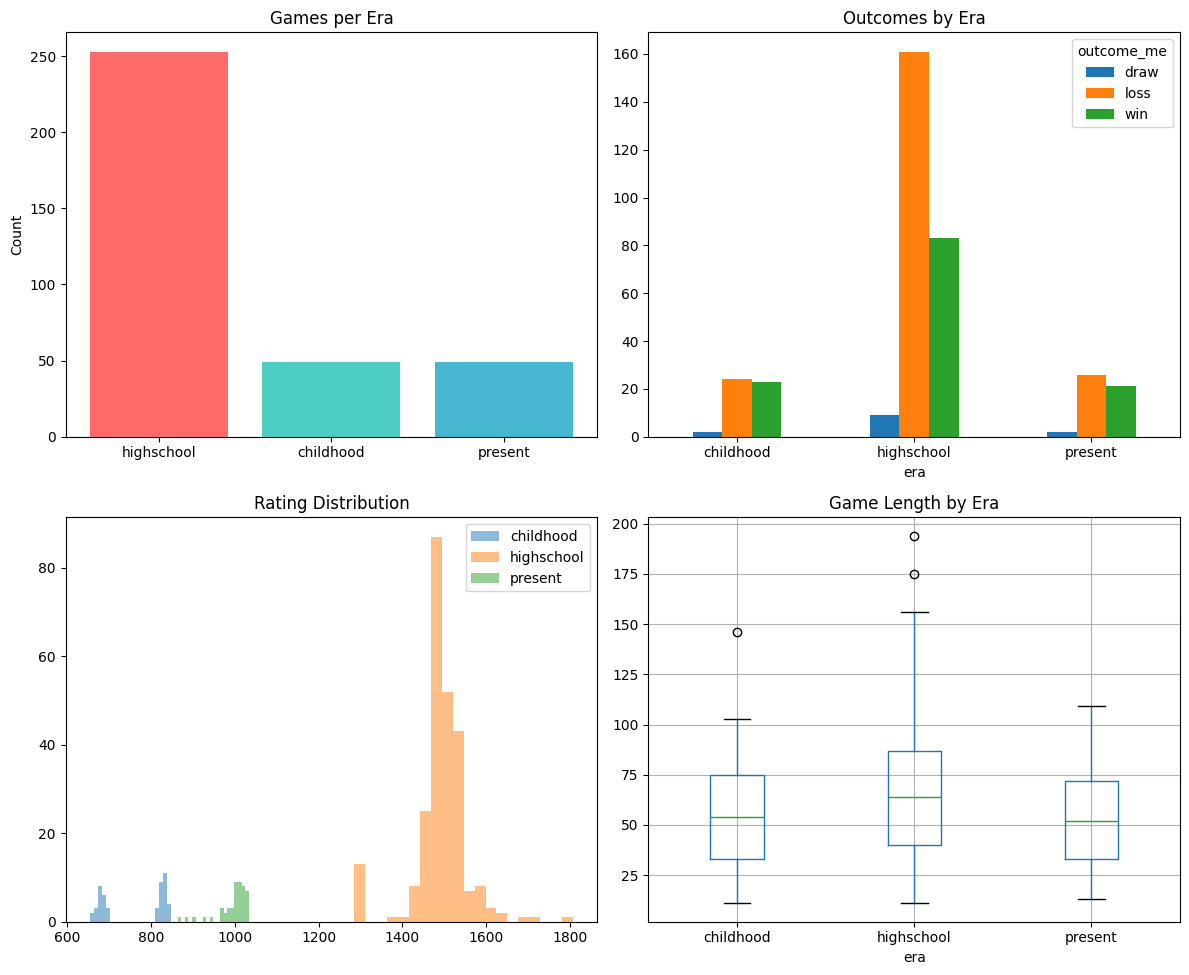

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

era_counts = df_features['era'].value_counts()
axes[0, 0].bar(era_counts.index, era_counts.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0, 0].set_title('Games per Era'); axes[0, 0].set_ylabel('Count')

outcome_era = df_features.groupby(['era', 'outcome_me']).size().unstack(fill_value=0)
outcome_era.plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Outcomes by Era'); axes[0, 1].tick_params(axis='x', rotation=0)

for era in ['childhood', 'highschool', 'present']:
    data = df_features[df_features['era'] == era]['me_elo'].dropna()
    if len(data) > 0: axes[1, 0].hist(data, alpha=0.5, label=era, bins=20)
axes[1, 0].set_title('Rating Distribution'); axes[1, 0].legend()

df_features.boxplot(column='n_plies', by='era', ax=axes[1, 1])
axes[1, 1].set_title('Game Length by Era'); plt.suptitle('')
plt.tight_layout(); plt.show()

In [21]:
feature_cols = ['my_castled_by_N', 'my_queen_moved_by_N', 'my_pawn_moves_N', 
                'my_minor_moves_N', 'my_captures_N', 'my_checks_N']
print("Feature Means by Era:")
print(df_features.groupby('era')[feature_cols].mean().round(3))

Feature Means by Era:
            my_castled_by_N  my_queen_moved_by_N  my_pawn_moves_N  \
era                                                                 
childhood             0.122                0.551            4.061   
highschool            0.399                0.486            3.557   
present               0.265                0.531            4.143   

            my_minor_moves_N  my_captures_N  my_checks_N  
era                                                       
childhood              4.265          1.898        0.327  
highschool             4.798          1.810        0.241  
present                4.531          1.714        0.184  


---
## Next Steps

Data is cleaned and features extracted. Ready for:
1. Train/Test Split
2. Model Selection & Training
3. Evaluation

---

## Data Sources & References

### Chess.com Profile Data

This analysis uses data from two Chess.com accounts representing different periods of my chess journey:

#### Childhood Account: [Abdulrahmansoli](https://www.chess.com/member/Abdulrahmansoli)

| Attribute | Value |
|-----------|-------|
| **Username** | abdulrahmansoli |
| **Player ID** | 63375042 |
| **Country** | Egypt 🇪🇬 |
| **Status** | Basic |
| **League** | Crystal |
| **Joined** | July 2019 |
| **Followers** | 6 |

**Rating Statistics:**

| Time Control | Current | Best | Record (W/L/D) |
|--------------|---------|------|----------------|
| Rapid | 815 | 1101 | 76/79/6 |
| Blitz | 654 | 835 | 298/365/26 |
| Bullet | 467 | 812 | 29/50/0 |
| Daily | 397 | - | 0/2/0 |

**Archive Coverage:** 29 monthly archives from July 2019 to December 2025

---

#### Current Account: [AbdulrahmanSoliman2](https://www.chess.com/member/AbdulrahmanSoliman2)

| Attribute | Value |
|-----------|-------|
| **Username** | abdulrahmansoliman2 |
| **Player ID** | 78015894 |
| **Country** | Egypt 🇪🇬 |
| **Status** | Premium |
| **League** | Crystal |
| **Joined** | April 2020 |
| **Followers** | 1 |

**Rating Statistics:**

| Time Control | Current | Best | Record (W/L/D) |
|--------------|---------|------|----------------|
| Rapid | 1003 | 1308 | 55/69/4 |
| Blitz | 864 | 1573 | 11/29/0 |
| Bullet | 964 | - | 0/1/0 |

**Tactics Rating:** 1344 (highest)

**Archive Coverage:** 5 monthly archives from April 2020 to February 2026

---

### API References

Data was retrieved using the [Chess.com Public API](https://www.chess.com/news/view/published-data-api):

- Player Profile: `https://api.chess.com/pub/player/{username}`
- Player Stats: `https://api.chess.com/pub/player/{username}/stats`
- Game Archives: `https://api.chess.com/pub/player/{username}/games/archives`

*Data retrieved: February 13, 2026*